# Добавление нужных библиотек

In [1]:
!pip install protobuf==3.20

In [2]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"]="python"

In [3]:
%%capture
!pip install bigartm

In [4]:
%%capture
!pip install optuna

In [5]:
%%capture
!pip install gensim

In [6]:
import numpy as np
import artm
import optuna
import pandas as pd
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

# Подключение диска

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Создание классов тематической модели и тюнера гиперпараметров

Класс тематической модели:

In [10]:
class My_BigARTM_model():
    def __init__(
        self,
        data: pd.DataFrame = pd.DataFrame(),
        num_topics: int = 1,
        num_document_passes: int = 1,
        class_ids: dict[str, float] = {"@default_class": 1.0},
        num_processors: int = 8,
        path_vw: str = "./vw.txt",
        batch_size: int = 1000,
        dir_batches: str = "./batches",
        num_top_tokens: int = 10,
        regularizers: dict[str, float] = {},
        num_collection_passes: int = 1,
        plateau_perplexity: float = 0.1,
        plateau_coherence: float = 0.1,
        plateau_topics_purity: float = 0.1,
        epsilon: float = 0.0000001
    ):
        self.data = data.copy(deep=True)
        self.num_topics = num_topics
        self.num_document_passes = num_document_passes
        self.class_ids = class_ids
        self.num_processors = num_processors
        self.path_vw = path_vw
        self.batch_size = batch_size
        self.dir_batches = dir_batches
        self.num_top_tokens = num_top_tokens
        self.user_regularizers = regularizers
        self.num_collection_passes = num_collection_passes
        self.epsilon = epsilon

        self.perplexity_by_epoch = []
        self.coherence_by_epoch = []
        self.topic_purities_by_epoch = []

        self.plateau_perplexity = plateau_perplexity
        self.plateau_coherence = plateau_coherence
        self.plateau_topics_purity = plateau_topics_purity

        if data.empty:
            print(
                "Чтобы создать модель добавьте данные, на которых будет строиться модель"
            )
        else:
            self.__make_vowpal_wabbit__()
            self.__make_batches__()
            self.__make_model__()

        if self.user_regularizers:
            self.add_regularizers(self.user_regularizers)

    def __make_vowpal_wabbit__(self) -> None:
        f = open(self.path_vw, "w")

        for row in range(self.data.shape[0]):
            string = ""
            for column in self.data.columns:
                string += str(self.data.loc[row, column]) + " "

            f.write("doc_{0} ".format(row) + string.strip() + "\n")

    def __make_batches__(self) -> None:
        self.batches = artm.BatchVectorizer(
            data_path=self.path_vw,
            data_format="vowpal_wabbit",
            batch_size=self.batch_size,
            target_folder=self.dir_batches
        )

        self.dictionary = self.batches.dictionary

    def __make_model__(self) -> None:
        self.model = artm.ARTM(
            cache_theta=True,
            num_topics=self.num_topics,
            num_document_passes=self.num_document_passes,
            dictionary=self.dictionary,
            class_ids=self.class_ids,
            num_processors=8
        )

        self.__add_BigARTM_metrics__()

    def __add_BigARTM_metrics__(self) -> None:
        self.model.scores.add(
            artm.PerplexityScore(name='perplexity', dictionary=self.dictionary)
        )
        self.model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
        self.model.scores.add(
            artm.SparsityThetaScore(name='sparsity_theta_score')
        )
        self.model.scores.add(
            artm.TopTokensScore(
                name="top_tokens", num_tokens=self.num_top_tokens
            )
        )

    def __calc_coherence__(self) -> None:
        topics = []
        if "top_tokens" in self.model.score_tracker:
            last_tokens = self.model.score_tracker["top_tokens"].last_tokens
            topics = [last_tokens[topic] for topic in last_tokens]

        valid_topics = []
        for topic in topics:
            if isinstance(topic, list) and len(topic) > 0:
                valid_topics.append(topic)

        if not valid_topics:
            self.coherence = 0.0
            return

        texts = []
        for row in range(self.data.shape[0]):
            words = []
            for column in self.data.columns:
                cell_content = self.data.loc[row, column]
                if isinstance(cell_content, str) and cell_content.strip():
                    words += cell_content.split()
            if words:
                texts.append(words)

        if not texts:
            self.coherence = 0.0
            return

        try:
            dictionary = Dictionary(texts)
            coherence_model = CoherenceModel(
                topics=valid_topics,
                texts=texts,
                dictionary=dictionary,
                coherence="c_v"
            )
            self.coherence = coherence_model.get_coherence()
        except Exception as e:
            print(f"Ошибка при расчете когерентности: {e}")
            self.coherence = 0.0

    def __calc_phi__(self) -> None:
        self.phi = np.sort(self.model.get_phi(), axis=0)[::-1, :]

    def __calc_theta__(self) -> None:
        self.theta = self.model.get_theta()

    def __calc_topic_purity__(self, topic: int) -> None:
        return np.sum(self.phi[:, topic]) / self.phi.shape[0]

    def __calc_topics_purities__(self) -> None:
        topics = range(self.phi.shape[1])
        self.topic_purities = sum(
            [self.__calc_topic_purity__(topic) for topic in topics]
        ) / len(topics)

    def __calc_metrics__(self) -> None:
        self.perplexity = self.model.score_tracker['perplexity'].last_value
        self.sparsity_phi_score = self.model.score_tracker['sparsity_phi_score'
                                                          ].last_value
        self.sparsity_theta_score = self.model.score_tracker[
            'sparsity_theta_score'].last_value
        self.top_tokens = self.model.score_tracker['top_tokens'].last_tokens
        self.__calc_coherence__()
        self.__calc_phi__()
        self.__calc_topics_purities__()

    def add_data(self, data: pd.DataFrame) -> None:
        self.data = data

        self.__make_vowpal_wabbit__()
        self.__make_batches__()
        self.__make_model__()

    def add_regularizer(self, name: str, tau: float = 0.0) -> None:
        if name == "SmoothSparseThetaRegularizer":
            self.model.regularizers.add(
                artm.SmoothSparseThetaRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        elif name == "SmoothSparsePhiRegularizer":
            self.model.regularizers.add(
                artm.SmoothSparsePhiRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        elif name == "DecorrelatorPhiRegularizer":
            self.model.regularizers.add(
                artm.DecorrelatorPhiRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        elif name == "LabelRegularizationPhiRegularizer":
            self.model.regularizers.add(
                artm.LabelRegularizationPhiRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        elif name == "HierarchicalSparsityPhiRegularizer":
            self.model.regularizers.add(
                artm.HierarchicalSparsityPhiRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        elif name == "TopicSelectionThetaRegularizer":
            self.model.regularizers.add(
                artm.TopicSelectionThetaRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        elif name == "BitermsPhiRegularizer":
            self.model.regularizers.add(
                artm.BitermsPhiRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        elif name == "BackgroundTopicsRegularizer":
            self.model.regularizers.add(
                artm.BackgroundTopicsRegularizer(name=name, tau=tau)
            )
            self.user_regularizers[name] = tau
        else:
            print(
                "Регуляризатора {0} нет! Проверьте корректность названия!".
                format(name)
            )

    def add_regularizers(self, regularizers: dict[str, float]) -> None:
        for regularizer in regularizers:
            self.add_regularizer(regularizer, regularizers[regularizer])

    def calc_model(self):
        self.perplexity_by_epoch = []
        self.coherence_by_epoch = []
        self.topic_purities_by_epoch = []

        for epoch in range(self.num_collection_passes):
            self.model.fit_offline(
                batch_vectorizer=self.batches, num_collection_passes=1
            )
            self.__calc_metrics__()
            self.perplexity_by_epoch.append(self.perplexity)
            self.coherence_by_epoch.append(self.coherence)
            self.topic_purities_by_epoch.append(self.topic_purities)

            if epoch > 0:
                change_perplexity_by_percent = abs(
                    self.perplexity_by_epoch[epoch - 1] -
                    self.perplexity_by_epoch[epoch]
                ) / (self.perplexity_by_epoch[epoch - 1] + self.epsilon) * 100
                change_coherence_by_percent = abs(self.coherence_by_epoch[epoch - 1] - self.coherence_by_epoch[epoch]) / \
                                              (self.coherence_by_epoch[epoch - 1] + self.epsilon) * 100
                change_topics_purity_by_percent = abs(
                    self.topic_purities_by_epoch[epoch - 1] - self.topic_purities_by_epoch[epoch]) / \
                                                  (self.topic_purities_by_epoch[epoch - 1] + self.epsilon) * 100

                if change_perplexity_by_percent < self.plateau_perplexity and change_coherence_by_percent < self.plateau_coherence and change_topics_purity_by_percent < self.plateau_topics_purity:
                    break

    def get_perplexity(self) -> float:
        return self.perplexity

    def get_perplexity_by_epochs(self) -> list[float]:
        return self.perplexity_by_epoch

    def print_perplexity_by_epochs(self) -> None:
        plt.plot(
            range(len(self.perplexity_by_epoch)),
            self.perplexity_by_epoch,
            label="perplexity"
        )
        plt.title("График перплексии")
        plt.xlabel("Epoch")
        plt.ylabel("Perplexity")
        plt.legend()
        plt.show()

    def get_coherence(self) -> float:
        return self.coherence

    def get_coherence_by_epochs(self) -> list[float]:
        return self.coherence_by_epoch

    def print_coherence_by_epochs(self) -> None:
        plt.plot(
            range(len(self.coherence_by_epoch)),
            self.coherence_by_epoch,
            label="coherence"
        )
        plt.title("График когерентности")
        plt.xlabel("Epoch")
        plt.ylabel("Coherence")
        plt.legend()
        plt.show()

    def get_topic_purities(self) -> float:
        return self.topic_purities

    def get_topic_purities_by_epochs(self) -> list[float]:
        return self.topic_purities_by_epoch

    def print_topic_purities_by_epochs(self) -> None:
        plt.plot(
            range(len(self.topic_purities_by_epoch)),
            self.topic_purities_by_epoch,
            label="topic purities"
        )
        plt.title("График чистоты тем")
        plt.xlabel("Epoch")
        plt.ylabel("Topics purity")
        plt.legend()
        plt.show()

    def get_model(self):
        return self.model

    def save_model(self, dir_model: str = "./drive/MyDrive/model") -> None:
        self.model.dump_artm_model(dir_model)

Класс тюнера гиперпараметров:

In [11]:
class Hyperparameter_optimizer:
    def __init__(
        self,
        data: pd.DataFrame,
        n_trials: int = 50,
        num_topics: tuple[str, int, int] = ("num_topics", 6, 8),
        num_document_passes: tuple[str, int,
                                   int] = ("num_document_passes", 3, 7),
        num_collection_passes: tuple[str, int,
                                     int] = ("num_collection_passes", 3, 7),
        regularizers: dict[str, tuple[str, float, float]] = {
            "SmoothSparseThetaRegularizer": ('tau_theta', -2.0, 2.0),
            "SmoothSparsePhiRegularizer": ('tau_phi', -2.0, 2.0)
        },
        class_ids: dict[str, float] = {"@default_class": 1.0}
    ):
        self.data = data.copy(deep=True)
        self.n_trials = n_trials
        self.num_topics = num_topics
        self.num_document_passes = num_document_passes
        self.num_collection_passes = num_collection_passes
        self.regularizers = regularizers
        self.class_ids = class_ids

        self.robast_scaler = RobustScaler()

    def __generate_regularizers_dict__(self, trial) -> dict[str, float]:
        """Генерирует словарь с параметрами регуляризаторов для текущего trial"""
        reg_dict = {}
        for reg_name, (param_name, low, high) in self.regularizers.items():
            tau_value = trial.suggest_float(param_name, low, high)
            reg_dict[reg_name] = tau_value
        return reg_dict

    def __objective__(self, trial) -> tuple[float, float, float]:
        # Основные параметры модели
        num_topics = trial.suggest_int(
            self.num_topics[0], self.num_topics[1], self.num_topics[2]
        )
        num_document_passes = trial.suggest_int(
            self.num_document_passes[0], self.num_document_passes[1],
            self.num_document_passes[2]
        )
        num_collection_passes = trial.suggest_int(
            self.num_collection_passes[0], self.num_collection_passes[1],
            self.num_collection_passes[2]
        )

        # Динамическое создание параметров регуляризаторов
        regularizers_dict = self.__generate_regularizers_dict__(trial)
        class_ids = self.class_ids

        # Создание и расчет модели
        model = My_BigARTM_model(
            data=self.data,
            num_topics=num_topics,
            num_document_passes=num_document_passes,
            class_ids=class_ids,
            num_collection_passes=num_collection_passes,
            regularizers=regularizers_dict
        )
        model.calc_model()

        return model.get_perplexity(), model.get_coherence(
        ), model.get_topic_purities()

    def __extract_regularizers_params__(self, params: dict) -> dict[str, float]:
        """Извлекает параметры регуляризаторов из общего словаря параметров"""
        reg_params = {}
        for reg_name, (param_name, _, _) in self.regularizers.items():
            if param_name in params:
                reg_params[reg_name] = params[param_name]
        return reg_params

    def __select_best_trial__(self, study, weights):
        """Выбирает trial с минимальной взвешенной суммой метрик."""
        params_and_metrics = [
            (trial.params, trial.values) for trial in study.best_trials
        ]
        metrics = np.array([item[1] for item in params_and_metrics])

        scaled_metrics = np.zeros_like(metrics)
        for i in range(metrics.shape[1]):
            scaler = RobustScaler()
            scaled_column = scaler.fit_transform(metrics[:, i].reshape(-1, 1)
                                                ).flatten()
            if weights[i] < 0:
                scaled_column = -scaled_column
            scaled_metrics[:, i] = scaled_column

        scaled_params_and_metrics = [
            (item[0], item[1], scaled_metrics[i].tolist())
            for i, item in enumerate(params_and_metrics)
        ]

        return min(scaled_params_and_metrics, key=lambda trial: sum(trial[2]))

    def optimizer(self):
        study = optuna.create_study(
            directions=["minimize", "maximize", "maximize"]
        )
        study.optimize(self.__objective__, n_trials=self.n_trials)
        best_trial = self.__select_best_trial__(study, weights=[1, -1, -1])
        best_params = best_trial[0]

        # Извлечение основных параметров
        num_topics = best_params[self.num_topics[0]]
        num_document_passes = best_params[self.num_document_passes[0]]
        num_collection_passes = best_params[self.num_collection_passes[0]]

        # Извлечение параметров регуляризаторов
        regularizers_params = self.__extract_regularizers_params__(best_params)

        print("Лучшие параметры:")
        print(f"Количество тем: {num_topics}")
        print(f"Проходы по документу: {num_document_passes}")
        print(f"Проходы по коллекции: {num_collection_passes}")

        for reg_name, tau_value in regularizers_params.items():
            print(f"{reg_name}: {tau_value:.4f}")

        # Создание финальной модели
        final_model = My_BigARTM_model(
            data=self.data,
            num_topics=num_topics,
            num_document_passes=num_document_passes,
            num_collection_passes=num_collection_passes,
            regularizers=regularizers_params,
            class_ids=self.class_ids
        )
        final_model.calc_model()
        self.model = final_model

    # Остальные методы без изменений
    def get_model(self) -> My_BigARTM_model:
        return self.model

    def save_model(self, path_model: str = "./drive/MyDrive/model") -> None:
        self.model.model.dump_artm_model(path_model)

    def save_phi(self, path_phi: str = "./drive/MyDrive/phi.xlsx") -> None:
        self.model.model.get_phi().to_excel(path_phi)

    def save_theta(
        self, path_theta: str = "./drive/MyDrive/theta.xlsx"
    ) -> None:
        self.model.model.get_theta().T.to_excel(path_theta)

# Вычисление тематических моделей

## Без tfidf стоп-слов

Загрузка датасета

In [11]:
d_add = pd.read_excel("./prepeared_news_without_tfidf.xlsx")
d_add = d_add[["title", "summary", "content"]]
d_add = d_add.fillna("")

Вычисление оптимальных параметров модели

In [12]:
ho_add = Hyperparameter_optimizer(data=d_add, n_trials=5, regularizers={})
ho_add.optimizer()

[I 2025-06-07 06:57:47,520] A new study created in memory with name: no-name-ac9ac513-7c51-420c-81c9-74f434455b75
[I 2025-06-07 07:01:12,345] Trial 0 finished with values: [3427.818603515625, 0.36405366553216356, 5.345594112218117e-05] and parameters: {'num_topics': 8, 'num_document_passes': 5, 'num_collection_passes': 3}.
[I 2025-06-07 07:04:27,488] Trial 1 finished with values: [3448.964111328125, 0.35563792386658083, 5.3455937272163584e-05] and parameters: {'num_topics': 6, 'num_document_passes': 4, 'num_collection_passes': 3}.
[I 2025-06-07 07:10:05,179] Trial 2 finished with values: [3299.83203125, 0.41393932666155203, 5.3455931506619997e-05] and parameters: {'num_topics': 7, 'num_document_passes': 5, 'num_collection_passes': 5}.
[I 2025-06-07 07:15:48,143] Trial 3 finished with values: [3420.073974609375, 0.37920208661644755, 5.345596581539746e-05] and parameters: {'num_topics': 8, 'num_document_passes': 3, 'num_collection_passes': 5}.
[I 2025-06-07 07:20:14,838] Trial 4 finished

Лучшие параметры:
Количество тем: 7
Проходы по документу: 5
Проходы по коллекции: 5


Параметры модели

In [13]:
m_add = ho_add.get_model()

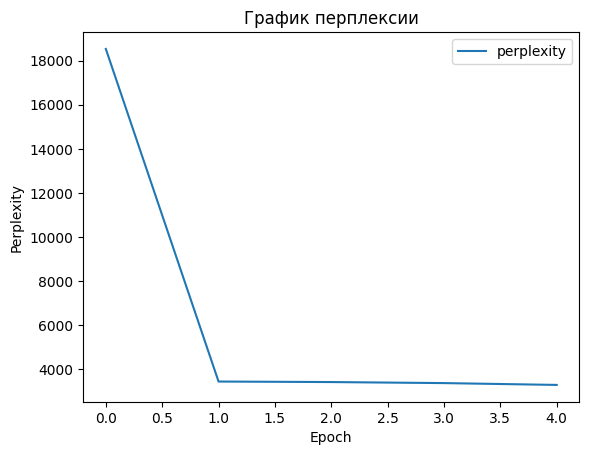

In [14]:
m_add.print_perplexity_by_epochs()

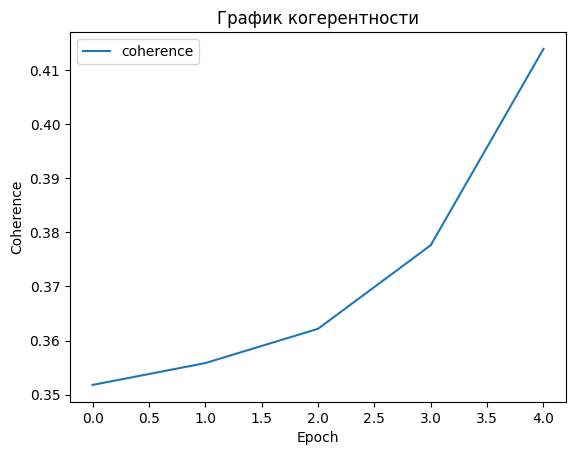

In [15]:
m_add.print_coherence_by_epochs()

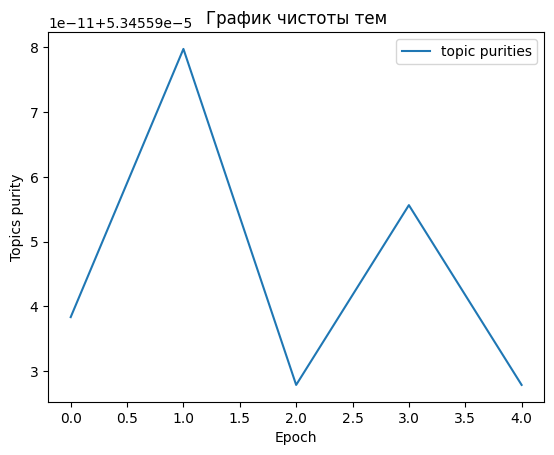

In [16]:
m_add.print_topic_purities_by_epochs()

Сохранение модели

In [17]:
ho_add.save_model("./drive/MyDrive/model_add")

In [18]:
ho_add.save_phi("./drive/MyDrive/phi_add.xlsx")

In [19]:
ho_add.save_theta("./drive/MyDrive/theta_add.xlsx")

## С tfidf стоп-словами 1 процент

Загрузка датасета

In [22]:
d_tfidf_1 = pd.read_excel("./prepeared_news_with_tfidf_1.xlsx")
d_tfidf_1 = d_tfidf_1[["title", "summary", "content"]]
d_tfidf_1 = d_tfidf_1.fillna("")

Вычисление оптимальных параметров модели

In [23]:
ho_tfidf_1 = Hyperparameter_optimizer(data=d_tfidf_1, n_trials=5, regularizers={})
ho_tfidf_1.optimizer()

[I 2025-06-07 07:37:38,096] A new study created in memory with name: no-name-7dcf6628-d02e-4b2c-a7f3-a1f428253a1a
[I 2025-06-07 07:42:37,591] Trial 0 finished with values: [3342.53515625, 0.4383848179377075, 5.345588337191729e-05] and parameters: {'num_topics': 8, 'num_document_passes': 7, 'num_collection_passes': 4}.
[I 2025-06-07 07:48:47,668] Trial 1 finished with values: [3472.6796875, 0.3977527985653486, 5.345597895856097e-05] and parameters: {'num_topics': 8, 'num_document_passes': 3, 'num_collection_passes': 5}.
[I 2025-06-07 07:57:00,679] Trial 2 finished with values: [3126.484619140625, 0.4762320753909479, 5.345601374147853e-05] and parameters: {'num_topics': 6, 'num_document_passes': 5, 'num_collection_passes': 7}.
[I 2025-06-07 08:00:45,115] Trial 3 finished with values: [3481.649169921875, 0.39227186236214123, 5.3455993296557516e-05] and parameters: {'num_topics': 8, 'num_document_passes': 5, 'num_collection_passes': 3}.
[I 2025-06-07 08:09:34,267] Trial 4 finished with val

Лучшие параметры:
Количество тем: 8
Проходы по документу: 7
Проходы по коллекции: 7


Параметры модели

In [24]:
m_tfidf_1 = ho_tfidf_1.get_model()

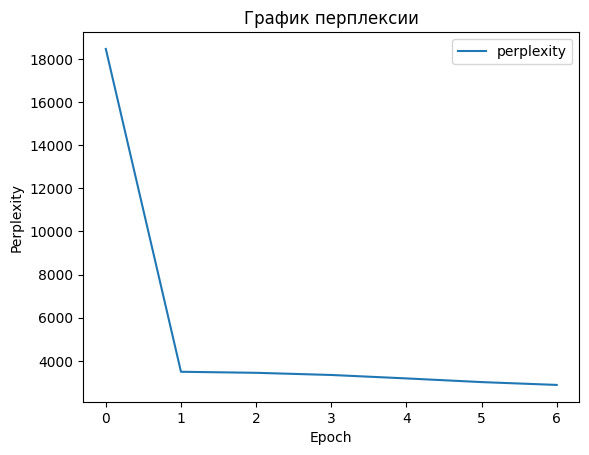

In [25]:
m_tfidf_1.print_perplexity_by_epochs()

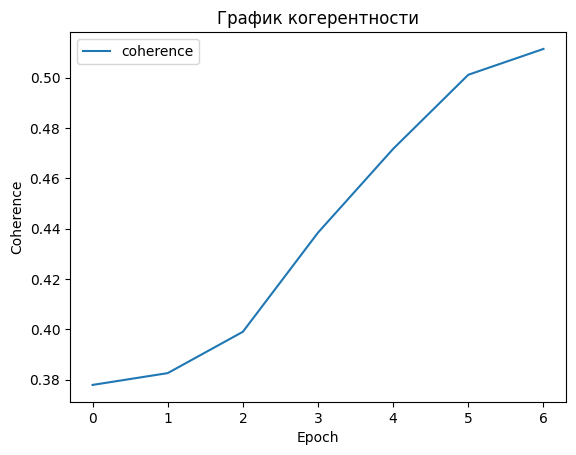

In [26]:
m_tfidf_1.print_coherence_by_epochs()

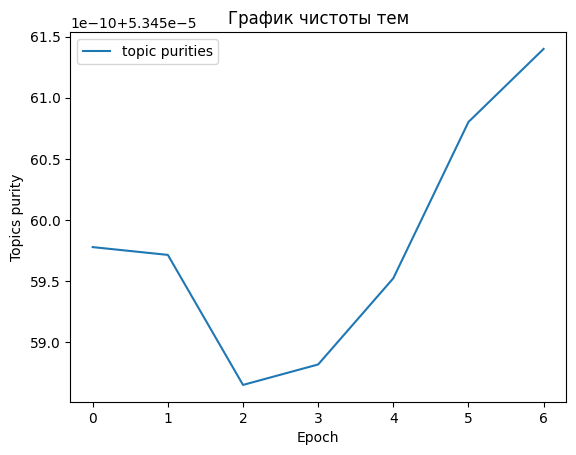

In [27]:
m_tfidf_1.print_topic_purities_by_epochs()

Сохранение модели

In [28]:
ho_tfidf_1.save_model("./drive/MyDrive/model_tfidf_1")

In [29]:
ho_tfidf_1.save_phi("./drive/MyDrive/phi_tfidf_1.xlsx")

In [30]:
ho_tfidf_1.save_theta("./drive/MyDrive/theta_tfidf_1.xlsx")

## С tfidf стоп-словами 2 процента

Загрузка датасета

In [31]:
d_tfidf_2 = pd.read_excel("./prepeared_news_with_tfidf_2.xlsx")
d_tfidf_2 = d_tfidf_2[["title", "summary", "content"]]
d_tfidf_2 = d_tfidf_2.fillna("")

Вычисление оптимальных параметров модели

In [32]:
ho_tfidf_2 = Hyperparameter_optimizer(data=d_tfidf_2, n_trials=5, regularizers={})
ho_tfidf_2.optimizer()

[I 2025-06-07 08:19:13,269] A new study created in memory with name: no-name-0c7b3083-b02d-4edd-a97f-13a350875da1
[I 2025-06-07 08:27:38,292] Trial 0 finished with values: [3403.55078125, 0.4618478814338354, 5.345593378249247e-05] and parameters: {'num_topics': 7, 'num_document_passes': 3, 'num_collection_passes': 7}.
[I 2025-06-07 08:32:23,560] Trial 1 finished with values: [3551.22607421875, 0.3884246832269159, 5.3455927865224055e-05] and parameters: {'num_topics': 7, 'num_document_passes': 3, 'num_collection_passes': 4}.
[I 2025-06-07 08:41:12,178] Trial 2 finished with values: [2972.05078125, 0.5184468051926799, 5.34560976453102e-05] and parameters: {'num_topics': 8, 'num_document_passes': 6, 'num_collection_passes': 7}.
[I 2025-06-07 08:48:40,744] Trial 3 finished with values: [3042.109375, 0.5165933849965978, 5.345607135898319e-05] and parameters: {'num_topics': 8, 'num_document_passes': 7, 'num_collection_passes': 6}.
[I 2025-06-07 08:55:42,819] Trial 4 finished with values: [33

Лучшие параметры:
Количество тем: 8
Проходы по документу: 6
Проходы по коллекции: 7


Параметры модели

In [33]:
m_tfidf_2 = ho_tfidf_2.get_model()

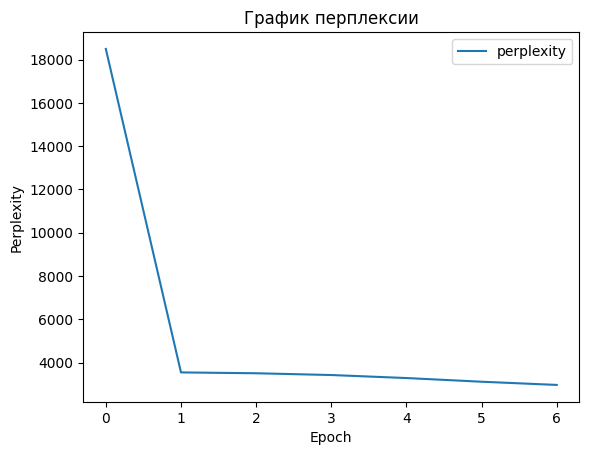

In [34]:
m_tfidf_2.print_perplexity_by_epochs()

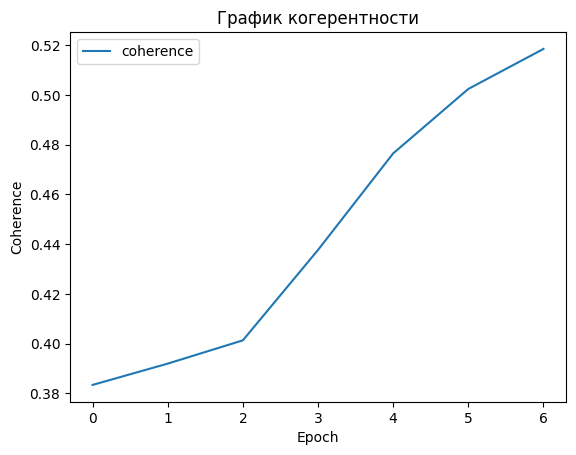

In [35]:
m_tfidf_2.print_coherence_by_epochs()

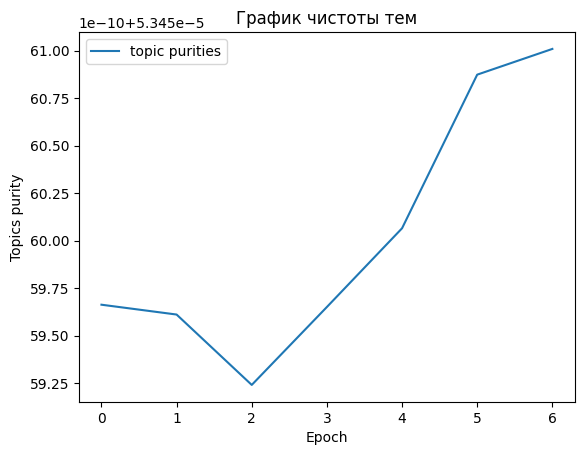

In [36]:
m_tfidf_2.print_topic_purities_by_epochs()

Сохранение модели

In [37]:
ho_tfidf_2.save_model("./drive/MyDrive/model_tfidf_2")

In [38]:
ho_tfidf_2.save_phi("./drive/MyDrive/phi_tfidf_2.xlsx")

In [39]:
ho_tfidf_2.save_theta("./drive/MyDrive/theta_tfidf_2.xlsx")

## С tfidf стоп-словами 3 процента

Загрузка датасета

In [42]:
d_tfidf_3 = pd.read_excel("./prepeared_news_with_tfidf_3.xlsx")
d_tfidf_3 = d_tfidf_3[["title", "summary", "content"]]
d_tfidf_3 = d_tfidf_3.fillna("")

Вычисление оптимальных параметров модели

In [43]:
ho_tfidf_3 = Hyperparameter_optimizer(data=d_tfidf_3, n_trials=5, regularizers={})
ho_tfidf_3.optimizer()

[I 2025-06-07 09:05:28,547] A new study created in memory with name: no-name-e5b2be52-652b-4e0b-a41f-678cbce14c19
[I 2025-06-07 09:13:59,818] Trial 0 finished with values: [2998.3173828125, 0.5252314707417565, 5.345608689181279e-05] and parameters: {'num_topics': 8, 'num_document_passes': 6, 'num_collection_passes': 7}.
[I 2025-06-07 09:22:18,957] Trial 1 finished with values: [3430.698974609375, 0.4672066847701043, 5.3455950680845545e-05] and parameters: {'num_topics': 8, 'num_document_passes': 3, 'num_collection_passes': 7}.
[I 2025-06-07 09:30:29,907] Trial 2 finished with values: [3057.76904296875, 0.4923331986171386, 5.3456052583035315e-05] and parameters: {'num_topics': 7, 'num_document_passes': 6, 'num_collection_passes': 7}.
[I 2025-06-07 09:35:02,065] Trial 3 finished with values: [3570.772216796875, 0.4066439442210464, 5.345589054091556e-05] and parameters: {'num_topics': 6, 'num_document_passes': 4, 'num_collection_passes': 4}.
[I 2025-06-07 09:40:51,405] Trial 4 finished wi

Лучшие параметры:
Количество тем: 8
Проходы по документу: 6
Проходы по коллекции: 7


Параметры модели

In [44]:
m_tfidf_3 = ho_tfidf_3.get_model()

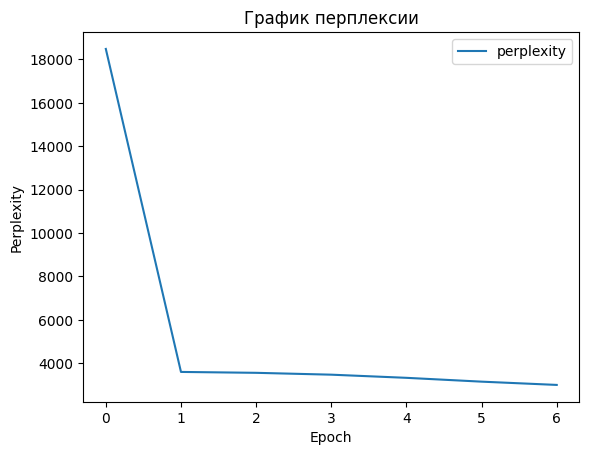

In [45]:
m_tfidf_3.print_perplexity_by_epochs()

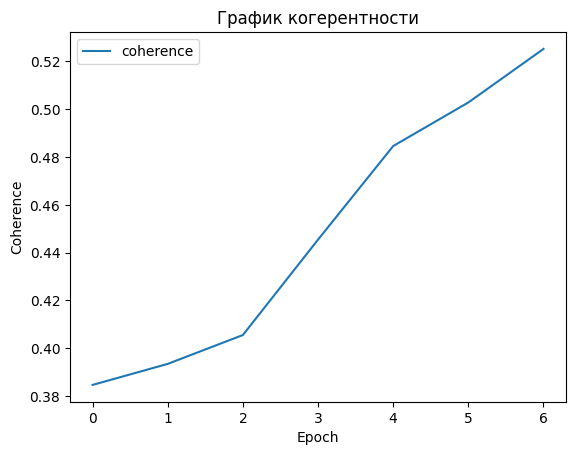

In [46]:
m_tfidf_3.print_coherence_by_epochs()

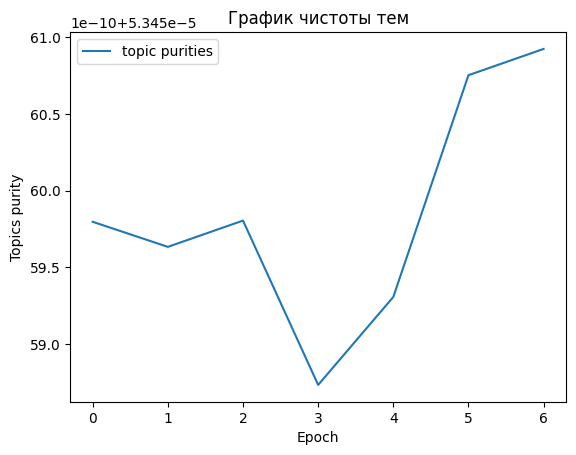

In [47]:
m_tfidf_3.print_topic_purities_by_epochs()

Сохранение модели

In [48]:
ho_tfidf_3.save_model("./drive/MyDrive/model_tfidf_3")

In [49]:
ho_tfidf_3.save_phi("./drive/MyDrive/phi_tfidf_3.xlsx")

In [50]:
ho_tfidf_3.save_theta("./drive/MyDrive/theta_tfidf_3.xlsx")

## С tfidf стоп-словами 4 процента

Загрузка датасета

In [51]:
d_tfidf_4 = pd.read_excel("./prepeared_news_with_tfidf_4.xlsx")
d_tfidf_4 = d_tfidf_4[["title", "summary", "content"]]
d_tfidf_4 = d_tfidf_4.fillna("")

Вычисление оптимальных параметров модели

In [52]:
ho_tfidf_4 = Hyperparameter_optimizer(data=d_tfidf_4, n_trials=5, regularizers={})
ho_tfidf_4.optimizer()

[I 2025-06-07 09:50:06,639] A new study created in memory with name: no-name-16782dd5-52e6-4c1c-9bf1-1cc559688a3a
[I 2025-06-07 09:54:47,646] Trial 0 finished with values: [3521.62255859375, 0.4487323071940877, 5.345584820968766e-05] and parameters: {'num_topics': 7, 'num_document_passes': 6, 'num_collection_passes': 4}.
[I 2025-06-07 09:58:13,294] Trial 1 finished with values: [3629.550537109375, 0.4089172536034699, 5.3455909658244295e-05] and parameters: {'num_topics': 6, 'num_document_passes': 5, 'num_collection_passes': 3}.
[I 2025-06-07 10:06:18,444] Trial 2 finished with values: [3478.891845703125, 0.4693776674764752, 5.345595836191512e-05] and parameters: {'num_topics': 7, 'num_document_passes': 3, 'num_collection_passes': 7}.
[I 2025-06-07 10:13:05,087] Trial 3 finished with values: [3569.985595703125, 0.44811346256878837, 5.3455946299791045e-05] and parameters: {'num_topics': 6, 'num_document_passes': 3, 'num_collection_passes': 6}.
[I 2025-06-07 10:18:56,845] Trial 4 finished

Лучшие параметры:
Количество тем: 7
Проходы по документу: 3
Проходы по коллекции: 7


Параметры модели

In [53]:
m_tfidf_4 = ho_tfidf_4.get_model()

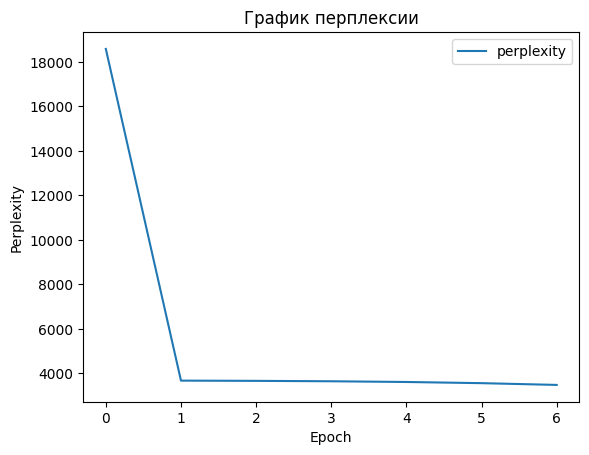

In [54]:
m_tfidf_4.print_perplexity_by_epochs()

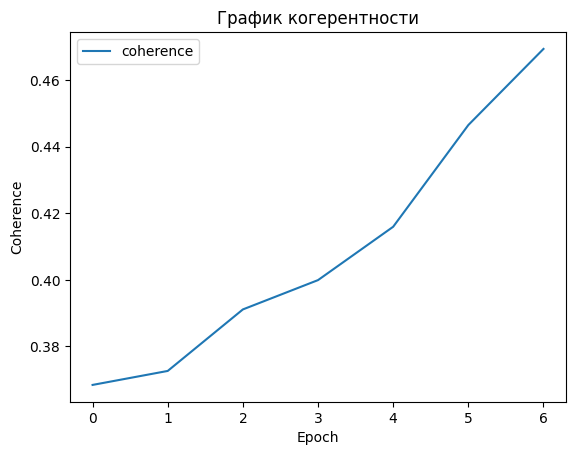

In [55]:
m_tfidf_4.print_coherence_by_epochs()

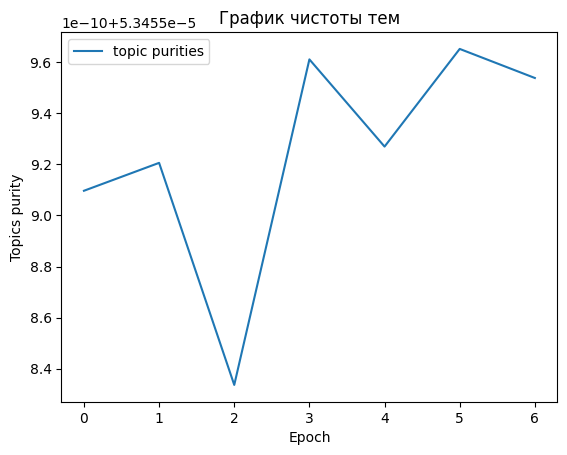

In [56]:
m_tfidf_4.print_topic_purities_by_epochs()

Сохранение модели

In [57]:
ho_tfidf_4.save_model("./drive/MyDrive/model_tfidf_4")

In [58]:
ho_tfidf_4.save_phi("./drive/MyDrive/phi_tfidf_4.xlsx")

In [59]:
ho_tfidf_4.save_theta("./drive/MyDrive/theta_tfidf_4.xlsx")

## С tfidf стоп-словами 5 процентов

Загрузка датасета

In [60]:
d_tfidf_5 = pd.read_excel("./prepeared_news_with_tfidf_5.xlsx")
d_tfidf_5 = d_tfidf_5[["title", "summary", "content"]]
d_tfidf_5 = d_tfidf_5.fillna("")

Вычисление оптимальных параметров модели

In [61]:
ho_tfidf_5 = Hyperparameter_optimizer(data=d_tfidf_5, n_trials=5, regularizers={})
ho_tfidf_5.optimizer()

[I 2025-06-07 10:32:13,979] A new study created in memory with name: no-name-0d0c1c73-d217-452e-969f-bedfc7646ded
[I 2025-06-07 10:40:16,382] Trial 0 finished with values: [3533.490478515625, 0.47392569318283034, 5.345594470668032e-05] and parameters: {'num_topics': 6, 'num_document_passes': 3, 'num_collection_passes': 7}.
[I 2025-06-07 10:48:32,855] Trial 1 finished with values: [3499.298828125, 0.4790667455760713, 5.345597298439573e-05] and parameters: {'num_topics': 8, 'num_document_passes': 3, 'num_collection_passes': 7}.
[I 2025-06-07 10:55:22,024] Trial 2 finished with values: [3498.23046875, 0.47821313666624404, 5.3455949486012494e-05] and parameters: {'num_topics': 6, 'num_document_passes': 4, 'num_collection_passes': 6}.
[I 2025-06-07 11:03:25,510] Trial 3 finished with values: [3374.431884765625, 0.4945402250091325, 5.345593461697904e-05] and parameters: {'num_topics': 6, 'num_document_passes': 4, 'num_collection_passes': 7}.
[I 2025-06-07 11:09:13,853] Trial 4 finished with 

Лучшие параметры:
Количество тем: 6
Проходы по документу: 4
Проходы по коллекции: 7


Параметры модели

In [62]:
m_tfidf_5 = ho_tfidf_5.get_model()

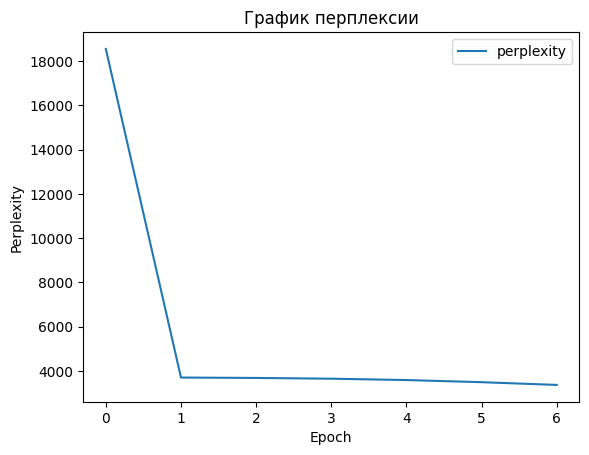

In [63]:
m_tfidf_5.print_perplexity_by_epochs()

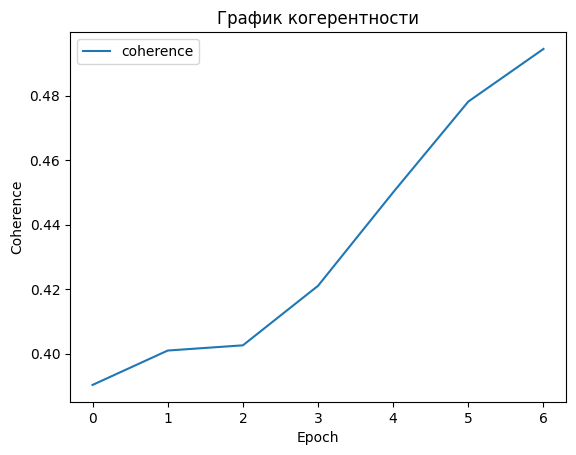

In [64]:
m_tfidf_5.print_coherence_by_epochs()

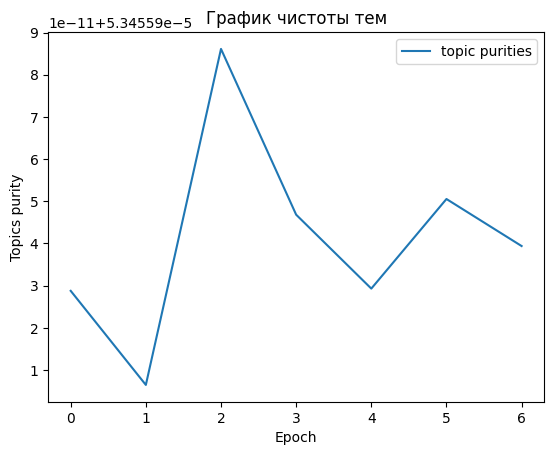

In [65]:
m_tfidf_5.print_topic_purities_by_epochs()

Сохранение модели

In [66]:
ho_tfidf_5.save_model("./drive/MyDrive/model_tfidf_5")

In [67]:
ho_tfidf_5.save_phi("./drive/MyDrive/phi_tfidf_5.xlsx")

In [68]:
ho_tfidf_5.save_theta("./drive/MyDrive/theta_tfidf_5.xlsx")

## С tfidf стоп-словами 6 процентов

Загрузка датасета

In [69]:
d_tfidf_6 = pd.read_excel("./prepeared_news_with_tfidf_6.xlsx")
d_tfidf_6 = d_tfidf_6[["title", "summary", "content"]]
d_tfidf_6 = d_tfidf_6.fillna("")

Вычисление оптимальных параметров модели

In [70]:
ho_tfidf_6 = Hyperparameter_optimizer(data=d_tfidf_6, n_trials=5, regularizers={})
ho_tfidf_6.optimizer()

[I 2025-06-07 11:22:07,771] A new study created in memory with name: no-name-3e5a6e90-1f70-4113-be52-b753ef008372
[I 2025-06-07 11:25:45,495] Trial 0 finished with values: [3656.456298828125, 0.424067494633558, 5.3455995686223604e-05] and parameters: {'num_topics': 8, 'num_document_passes': 7, 'num_collection_passes': 3}.
[I 2025-06-07 11:29:11,780] Trial 1 finished with values: [3712.887451171875, 0.42233048705250487, 5.345591072031811e-05] and parameters: {'num_topics': 6, 'num_document_passes': 5, 'num_collection_passes': 3}.
[I 2025-06-07 11:33:58,325] Trial 2 finished with values: [3634.603759765625, 0.43412383711165137, 5.3455946299791045e-05] and parameters: {'num_topics': 8, 'num_document_passes': 5, 'num_collection_passes': 4}.
[I 2025-06-07 11:42:10,493] Trial 3 finished with values: [3364.7451171875, 0.49554986987084765, 5.345605030716285e-05] and parameters: {'num_topics': 7, 'num_document_passes': 4, 'num_collection_passes': 7}.
[I 2025-06-07 11:46:45,886] Trial 4 finished

Лучшие параметры:
Количество тем: 7
Проходы по документу: 4
Проходы по коллекции: 7


Параметры модели

In [71]:
m_tfidf_6 = ho_tfidf_6.get_model()

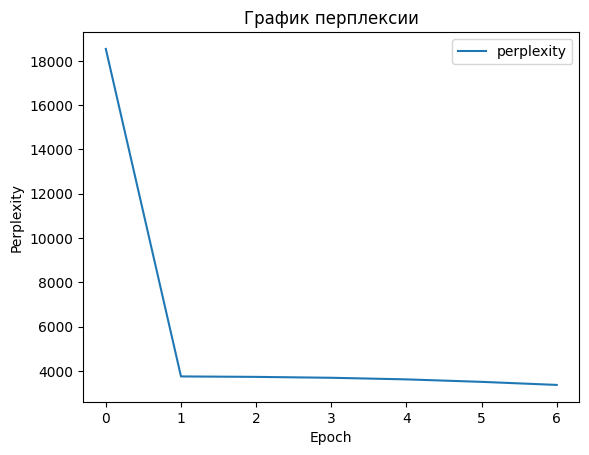

In [72]:
m_tfidf_6.print_perplexity_by_epochs()

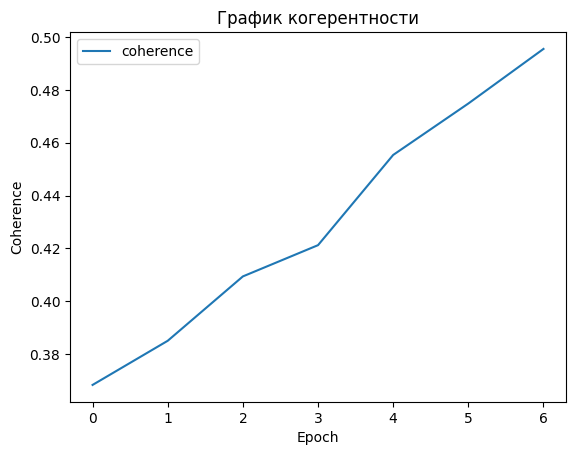

In [73]:
m_tfidf_6.print_coherence_by_epochs()

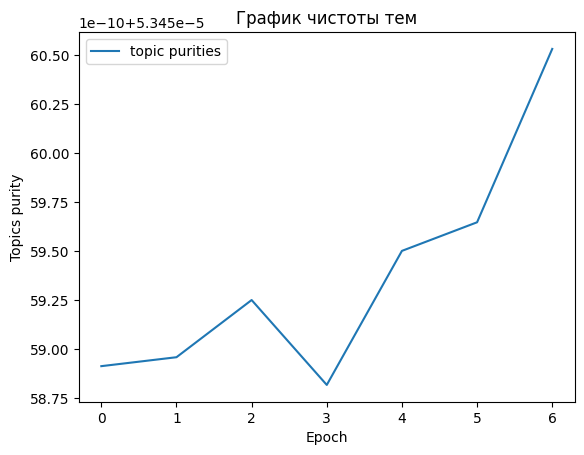

In [74]:
m_tfidf_6.print_topic_purities_by_epochs()

Сохранение модели

In [75]:
ho_tfidf_6.save_model("./drive/MyDrive/model_tfidf_6")

In [76]:
ho_tfidf_6.save_phi("./drive/MyDrive/phi_tfidf_6.xlsx")

In [77]:
ho_tfidf_6.save_theta("./drive/MyDrive/theta_tfidf_6.xlsx")

## С tfidf стоп-словами 7 процентов

Загрузка датасета

In [78]:
d_tfidf_7 = pd.read_excel("./prepeared_news_with_tfidf_7.xlsx")
d_tfidf_7 = d_tfidf_7[["title", "summary", "content"]]
d_tfidf_7 = d_tfidf_7.fillna("")

Вычисление оптимальных параметров модели

In [79]:
ho_tfidf_7 = Hyperparameter_optimizer(data=d_tfidf_7, n_trials=5, regularizers={})
ho_tfidf_7.optimizer()

[I 2025-06-07 11:55:40,737] A new study created in memory with name: no-name-ca24de29-9d37-4eb9-adee-f2c5780bb1c4
[I 2025-06-07 12:04:04,724] Trial 0 finished with values: [3158.458984375, 0.5019975568615621, 5.345613587996767e-05] and parameters: {'num_topics': 7, 'num_document_passes': 6, 'num_collection_passes': 7}.
[I 2025-06-07 12:10:04,559] Trial 1 finished with values: [3479.333740234375, 0.48256322189956186, 5.3455952899821186e-05] and parameters: {'num_topics': 7, 'num_document_passes': 6, 'num_collection_passes': 5}.
[I 2025-06-07 12:13:35,544] Trial 2 finished with values: [3788.642578125, 0.3891030733063429, 5.345594988429018e-05] and parameters: {'num_topics': 8, 'num_document_passes': 3, 'num_collection_passes': 3}.
[I 2025-06-07 12:22:00,455] Trial 3 finished with values: [3158.458984375, 0.5019975568615621, 5.345613223857172e-05] and parameters: {'num_topics': 7, 'num_document_passes': 6, 'num_collection_passes': 7}.
[I 2025-06-07 12:27:52,902] Trial 4 finished with val

Лучшие параметры:
Количество тем: 7
Проходы по документу: 6
Проходы по коллекции: 7


Параметры модели

In [80]:
m_tfidf_7 = ho_tfidf_7.get_model()

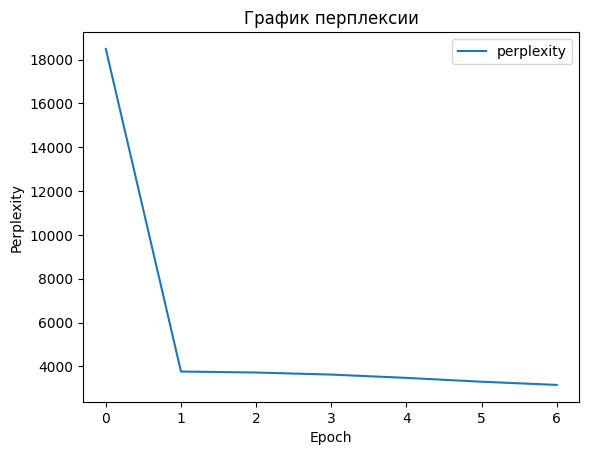

In [81]:
m_tfidf_7.print_perplexity_by_epochs()

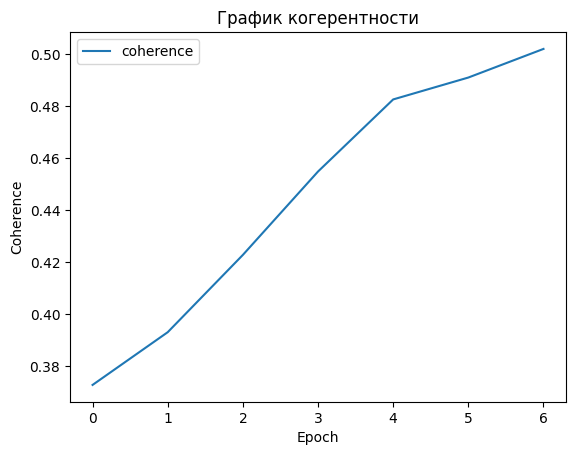

In [82]:
m_tfidf_7.print_coherence_by_epochs()

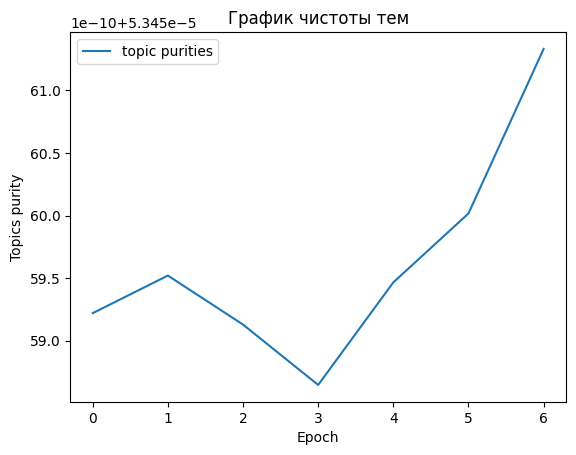

In [83]:
m_tfidf_7.print_topic_purities_by_epochs()

Сохранение модели

In [84]:
ho_tfidf_7.save_model("./drive/MyDrive/model_tfidf_7")

In [85]:
ho_tfidf_7.save_phi("./drive/MyDrive/phi_tfidf_7.xlsx")

In [86]:
ho_tfidf_7.save_theta("./drive/MyDrive/theta_tfidf_7.xlsx")

## С tfidf стоп-словами 8 процентов

Загрузка датасета

In [11]:
d_tfidf_8 = pd.read_excel("./prepeared_news_with_tfidf_8.xlsx")
d_tfidf_8 = d_tfidf_8[["title", "summary", "content"]]
d_tfidf_8 = d_tfidf_8.fillna("")

Вычисление оптимальных параметров модели

In [12]:
ho_tfidf_8 = Hyperparameter_optimizer(data=d_tfidf_8, n_trials=5, regularizers={})
ho_tfidf_8.optimizer()

[I 2025-06-09 13:46:18,656] A new study created in memory with name: no-name-6cb41b76-3b22-42c5-9722-3ebbbe44ccfb
[I 2025-06-09 13:52:42,671] Trial 0 finished with values: [3806.10693359375, 0.4129930110575885, 5.3455905561673854e-05] and parameters: {'num_topics': 7, 'num_document_passes': 3, 'num_collection_passes': 4}.
[I 2025-06-09 14:01:06,636] Trial 1 finished with values: [3391.54931640625, 0.5091469414837042, 5.3455967010230505e-05] and parameters: {'num_topics': 8, 'num_document_passes': 7, 'num_collection_passes': 5}.
[I 2025-06-09 14:08:45,554] Trial 2 finished with values: [3774.65869140625, 0.4543719043637447, 5.3455931430757585e-05] and parameters: {'num_topics': 6, 'num_document_passes': 3, 'num_collection_passes': 5}.
[I 2025-06-09 14:13:16,998] Trial 3 finished with values: [3830.588623046875, 0.40141864228056034, 5.3456001527629603e-05] and parameters: {'num_topics': 6, 'num_document_passes': 3, 'num_collection_passes': 3}.
[I 2025-06-09 14:21:09,787] Trial 4 finished

Лучшие параметры:
Количество тем: 8
Проходы по документу: 7
Проходы по коллекции: 5


Параметры модели

In [13]:
m_tfidf_8 = ho_tfidf_8.get_model()

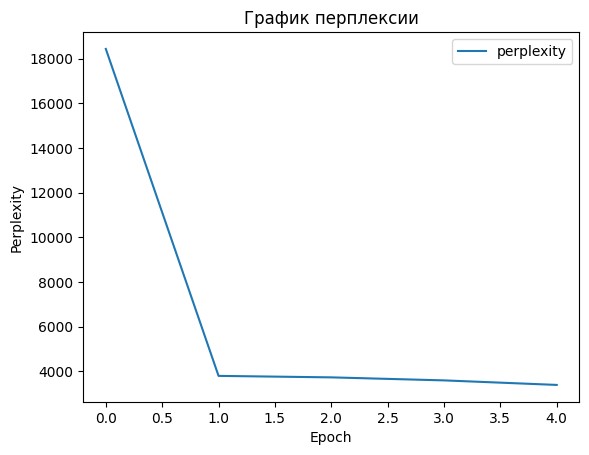

In [14]:
m_tfidf_8.print_perplexity_by_epochs()

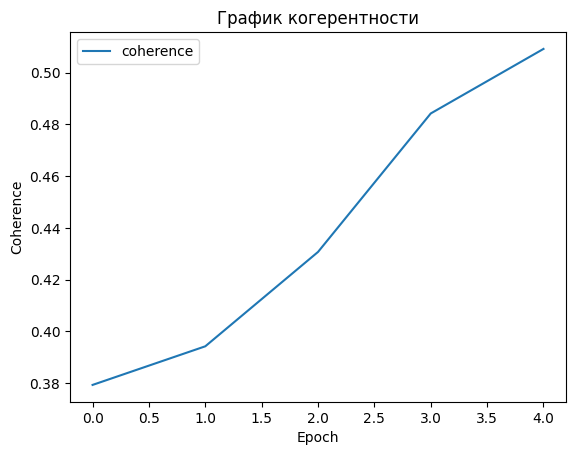

In [15]:
m_tfidf_8.print_coherence_by_epochs()

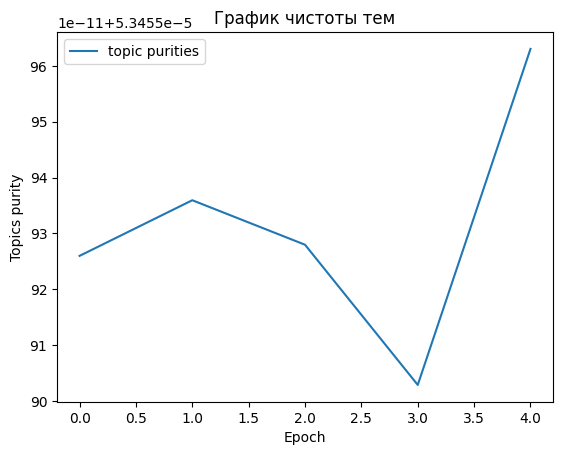

In [16]:
m_tfidf_8.print_topic_purities_by_epochs()

Сохранение модели

In [17]:
ho_tfidf_8.save_model("./drive/MyDrive/model_tfidf_8")

In [18]:
ho_tfidf_8.save_phi("./drive/MyDrive/phi_tfidf_8.xlsx")

In [19]:
ho_tfidf_8.save_theta("./drive/MyDrive/theta_tfidf_8.xlsx")

## С tfidf стоп-словами 9 процентов

Загрузка датасета

In [12]:
d_tfidf_9 = pd.read_excel("./prepeared_news_with_tfidf_9.xlsx")
d_tfidf_9 = d_tfidf_9[["title", "summary", "content"]]
d_tfidf_9 = d_tfidf_9.fillna("")

Вычисление оптимальных параметров модели

In [13]:
ho_tfidf_9 = Hyperparameter_optimizer(data=d_tfidf_9, n_trials=5, regularizers={})
ho_tfidf_9.optimizer()

[I 2025-06-10 07:32:53,426] A new study created in memory with name: no-name-3f69e76d-e70d-478f-a61f-4208ec496390
[I 2025-06-10 07:37:01,626] Trial 0 finished with values: [3764.25927734375, 0.43743684686233136, 5.345595546017773e-05] and parameters: {'num_topics': 8, 'num_document_passes': 7, 'num_collection_passes': 3}.
[I 2025-06-10 07:44:30,694] Trial 1 finished with values: [3749.02294921875, 0.4631911272449494, 5.345599356207597e-05] and parameters: {'num_topics': 6, 'num_document_passes': 3, 'num_collection_passes': 6}.
[I 2025-06-10 07:51:57,301] Trial 2 finished with values: [3620.92724609375, 0.493803197850429, 5.3456006837998705e-05] and parameters: {'num_topics': 6, 'num_document_passes': 4, 'num_collection_passes': 6}.
[I 2025-06-10 07:58:09,601] Trial 3 finished with values: [3801.713623046875, 0.44825137621717, 5.345593378249246e-05] and parameters: {'num_topics': 7, 'num_document_passes': 3, 'num_collection_passes': 5}.
[I 2025-06-10 08:05:55,291] Trial 4 finished with 

Лучшие параметры:
Количество тем: 8
Проходы по документу: 7
Проходы по коллекции: 6


Параметры модели

In [14]:
m_tfidf_9 = ho_tfidf_9.get_model()

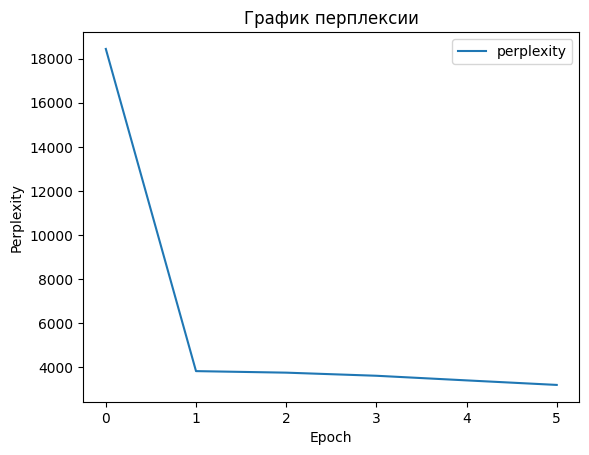

In [15]:
m_tfidf_9.print_perplexity_by_epochs()

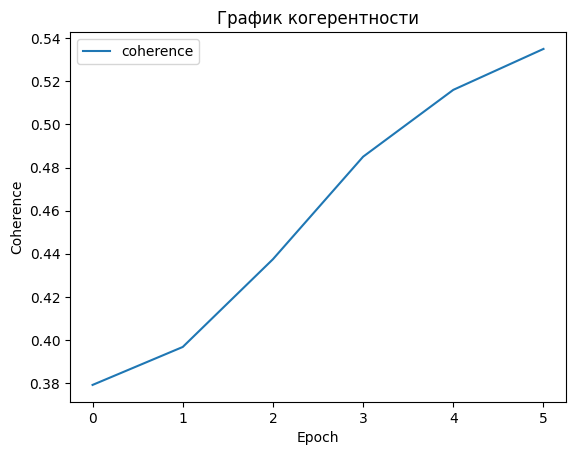

In [16]:
m_tfidf_9.print_coherence_by_epochs()

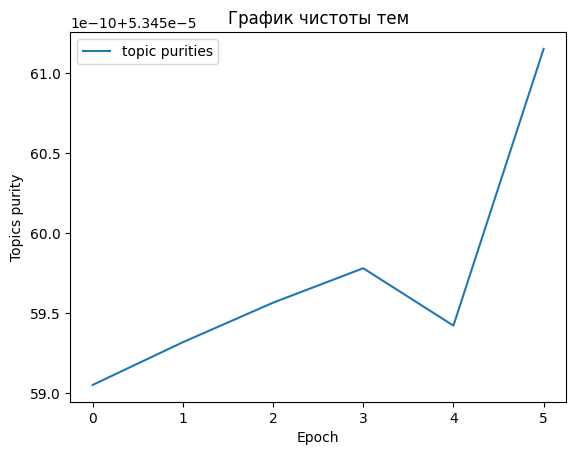

In [17]:
m_tfidf_9.print_topic_purities_by_epochs()

Сохранение модели

In [18]:
ho_tfidf_9.save_model("./drive/MyDrive/model_tfidf_9")

In [19]:
ho_tfidf_9.save_phi("./drive/MyDrive/phi_tfidf_9.xlsx")

In [20]:
ho_tfidf_9.save_theta("./drive/MyDrive/theta_tfidf_9.xlsx")

## С tfidf стоп-словами 10 процентов

Загрузка датасета

In [21]:
d_tfidf_10 = pd.read_excel("./prepeared_news_with_tfidf_10.xlsx")
d_tfidf_10 = d_tfidf_10[["title", "summary", "content"]]
d_tfidf_10 = d_tfidf_10.fillna("")

Вычисление оптимальных параметров модели

In [22]:
ho_tfidf_10 = Hyperparameter_optimizer(data=d_tfidf_10, n_trials=5, regularizers={})
ho_tfidf_10.optimizer()

[I 2025-06-10 08:16:34,995] A new study created in memory with name: no-name-3cd0913d-0d5f-4782-9f63-a80f4a69d501
[I 2025-06-10 08:26:29,494] Trial 0 finished with values: [3642.526123046875, 0.49507020270107127, 5.345603631054718e-05] and parameters: {'num_topics': 8, 'num_document_passes': 3, 'num_collection_passes': 7}.
[I 2025-06-10 08:35:55,020] Trial 1 finished with values: [3687.564453125, 0.48962882950753067, 5.345593992734813e-05] and parameters: {'num_topics': 6, 'num_document_passes': 3, 'num_collection_passes': 7}.
[I 2025-06-10 08:41:25,541] Trial 2 finished with values: [3675.627197265625, 0.47469160368407787, 5.345598885860621e-05] and parameters: {'num_topics': 7, 'num_document_passes': 7, 'num_collection_passes': 4}.
[I 2025-06-10 08:48:05,496] Trial 3 finished with values: [3649.260498046875, 0.4719989753782249, 5.345590692719734e-05] and parameters: {'num_topics': 7, 'num_document_passes': 5, 'num_collection_passes': 5}.
[I 2025-06-10 08:57:39,896] Trial 4 finished w

Лучшие параметры:
Количество тем: 8
Проходы по документу: 6
Проходы по коллекции: 7


Параметры модели

In [23]:
m_tfidf_10 = ho_tfidf_10.get_model()

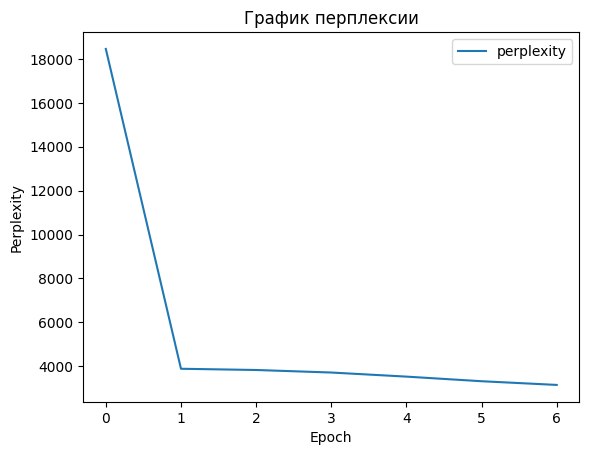

In [24]:
m_tfidf_10.print_perplexity_by_epochs()

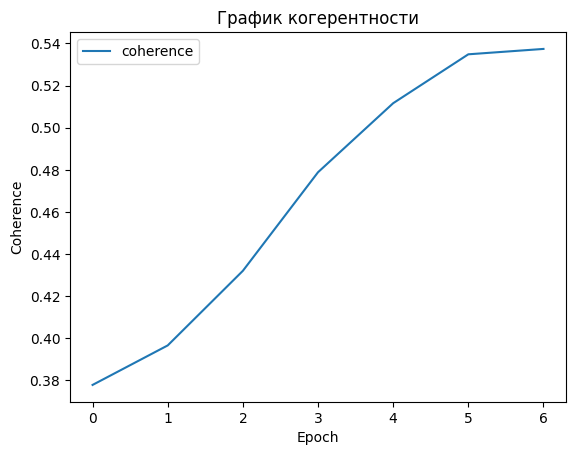

In [25]:
m_tfidf_10.print_coherence_by_epochs()

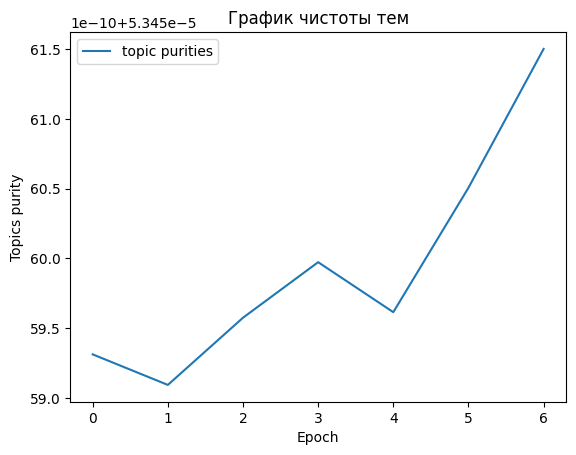

In [26]:
m_tfidf_10.print_topic_purities_by_epochs()

Сохранение модели

In [27]:
ho_tfidf_10.save_model("./drive/MyDrive/model_tfidf_10")

In [28]:
ho_tfidf_10.save_phi("./drive/MyDrive/phi_tfidf_10.xlsx")

In [29]:
ho_tfidf_10.save_theta("./drive/MyDrive/theta_tfidf_10.xlsx")